In [214]:
%matplotlib inline
import os
import skimage
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot
import numpy as np
import PIL
import torch
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt

Author: Jia Lin Gao 2020

This notebook is adapted from blockquoted tutorial below



>What is `torch.nn` *really*?
============================
by Jeremy Howard, `fast.ai <https://www.fast.ai>`_. Thanks to Rachel Thomas and Francisco Ingham.


In [6]:
DATA_PATH = os.getcwd()+"/data"
PATH = Path(DATA_PATH+"/mnist")

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

>This dataset is in numpy array format, and has been stored using pickle,
a python-specific format for serializing data.



In [7]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

>Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



In [39]:
def showTensor(x, dim = 28, idx = 0):
    if x.shape[1]==dim:
        pyplot.imshow(x.numpy(), cmap="gray")
    else:
        pyplot.imshow(x[idx].detach().numpy().reshape((dim,dim)), cmap='gray')
    
showTensor(x_train, 28)
print(x_train.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

We can now play with some matrix and image transformations using PIL and Numpy

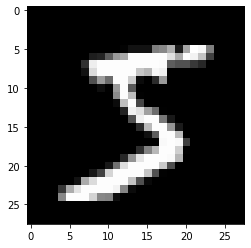

In [30]:
e1 = x_train[0].reshape((28,28))
showTensor(e1)

Lets convert it into unsigned int form so we can then convert them to PIL format and use the PIL library for image transformations

In [10]:
e2 = np.uint8(e1*255)

Pil does the downsampling for us wew

AttributeError: 'Image' object has no attribute 'numpy'

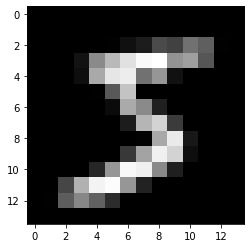

In [38]:
e3 = PIL.Image.fromarray(e2)
e4 = e3.resize((14, 14))
pyplot.imshow(e4, cmap="gray")
showTensor(e4)

The PIL library can also upsample for us which is convenient - no need to do it manually

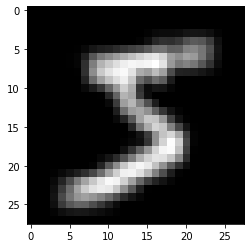

In [37]:
e5 = e4.resize((28,28),resample = 3)
pyplot.imshow(e5, cmap="gray")

We can then calculate mean absolute error, mean squared error and structural similarity index

In [13]:
e5_mae = np.average(np.asarray(e5) - np.asarray(e3))
e5_mse = np.average(np.square(np.asarray(e5)-np.asarray(e3))) 

print("The MSE of bicubic interpolation on this image is", e5_mse)
e5_ssim = ssim(np.asarray(e5), np.asarray(e3))
print("The SSIM of bicubic interpolation on this image is", e5_ssim)


The MSE of bicubic interpolation on this image is 40.17602040816327
The SSIM of bicubic interpolation on this image is 0.839661764924514


/projects/qg35/jlgao2/venvs/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


We've validated the approach, now lets downsample the whole dataset

wew I just did a python


We can use much of the same code to obtain upsampleed images using bicubic or bilinear interpolations to measure the network that we will surely build ^__^


In [14]:
def downupsample(array):
  dsda = np.ones((array.shape[0],196)) 
  usda = np.ones((array.shape[0],784)) 

  for i in range(array.shape[0]):
    ar = array[i].reshape((28,28))
    ar = np.int8(ar*255)
    ar2 = PIL.Image.fromarray(ar)
    ar3 = ar2.resize((14,14))
    ar4 = np.asarray(ar3).reshape((1, 196))
    ar5 = ar4.astype(np.float64)/255
    dsda[i,:] = np.clip(ar5,0,1)
    ar6 = ar3.resize((28,28), resample = 3)
    ar7 = np.asarray(ar6).reshape((1, 784))
    ar8 = ar7.astype(np.float32)/255
    usda[i,:] = np.clip(ar8,0,1)
  return dsda, usda
xt_ds, xt_us = downupsample(x_train)
xv_ds, xv_us= downupsample(x_valid)


In [20]:
x_train, xt_ds, xt_us = map(
torch.tensor, (x_train, xt_ds, xt_us)
    )

x_valid, xv_ds, xv_us = map(
torch.tensor, (x_valid, xv_ds, xv_us)
    )

[n, c] = x_train.shape

x_train = x_train.float()
xt_ds = xt_ds.float()
xt_us = xt_us.float()
x_valid = x_valid.float()
xv_ds = xv_ds.float()
xv_us = xv_us.float()

/projects/qg35/jlgao2/venvs/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/projects/qg35/jlgao2/venvs/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [48]:
mse = []
ssim = []

for i in range(100):
    mse.append(np.average(np.square(np.asarray(xt_us[i])-np.asarray(x_train[i]))))
    ssim.append(compare_ssim(np.asarray(xt_us[i]), np.asarray(x_train[i])))

#     e5_mse =  
# from skimage.measure import compare_ssim as ssim
# print("The MSE of bicubic interpolation on this image is", e5_mse)
# e5_ssim = 
# print("The SSIM of bicubic interpolation on this image is", e5_ssim)

print(np.mean(mse))
print(np.mean(ssim))
    

0.010889884
0.8491649687219552


/projects/qg35/jlgao2/venvs/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


>Neural net from scratch (no torch.nn)
---------------------------------------------

>Let's first create a model using nothing but PyTorch tensor operations. We're assuming
you're already familiar with the basics of neural networks. (If you're not, you can
learn them at `course.fast.ai <https://course.fast.ai>`_).

>PyTorch provides methods to create random or zero-filled tensors, which we will
use to create our weights and bias for a simple linear model. These are just regular
tensors, with one very special addition: we tell PyTorch that they require a
gradient. This causes PyTorch to record all of the operations done on the tensor,
so that it can calculate the gradient during back-propagation *automatically*!

>For the weights, we set ``requires_grad`` **after** the initialization, since we
don't want that step included in the gradient. (Note that a trailling ``_`` in
PyTorch signifies that the operation is performed in-place.)

<div class="alert alert-info"><h4>Note</h4><p>We are initializing the weights here with
   `Xavier initialisation <http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf>`_
   (by multiplying with 1/sqrt(n)).</p></div>



In [49]:
import math

weights = torch.randn(196, 784) / 196
weights.requires_grad_()
bias = torch.zeros(784, requires_grad=True)

xt_ds.type()

'torch.FloatTensor'

>Thanks to PyTorch's ability to calculate gradients automatically, we can
use any standard Python function (or callable object) as a model! So
let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `log_softmax` and use it. Remember: although PyTorch
provides lots of pre-written loss functions, activation functions, and
so forth, you can easily write your own using plain python. PyTorch will
even create fast GPU or vectorized CPU code for your function
automatically.

For a regression problem we cannot use a log softmax, so we modify this model to use a Relu activation function. Jeremy Howard says it works better for classification problems anyway



In [50]:
def relu(x): #activation function
    return torch.clamp(x, 0, 1)

def model(xb): 
    return relu(xb @ weights + bias)

>In the above, the ``@`` stands for the dot product operation. We will call
our function on one batch of data (in this case, 64 images).  This is
one *forward pass*.  Note that our predictions won't be any better than
random at this stage, since we start with random weights.



In [51]:
bs = 64  # batch size

xb = xt_ds[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], weights[0], xt_ds[0])


tensor([4.9451e-02, 4.4994e-02, 0.0000e+00, 1.5130e-02, 1.8985e-02, 0.0000e+00,
        2.0024e-02, 2.1164e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.4662e-03, 0.0000e+00, 0.0000e+00, 1.9227e-02, 0.0000e+00, 6.0804e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0985e-02, 0.0000e+00, 1.2064e-02,
        7.2111e-03, 1.8518e-02, 2.7636e-02, 0.0000e+00, 1.9305e-03, 3.5012e-02,
        2.1956e-02, 0.0000e+00, 3.7554e-02, 0.0000e+00, 0.0000e+00, 2.6167e-02,
        0.0000e+00, 1.9710e-02, 8.7647e-03, 0.0000e+00, 2.5703e-02, 9.9076e-03,
        1.8519e-02, 0.0000e+00, 6.0988e-02, 1.1830e-02, 0.0000e+00, 0.0000e+00,
        2.0182e-03, 3.1915e-02, 1.0914e-02, 6.3087e-03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0874e-02, 0.0000e+00, 2.5244e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.5343e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0243e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.2911e-

In [52]:
print(torch.max(preds[0]))

tensor(0.0684, grad_fn=<MaxBackward1>)


>As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

>Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):

Well we can't use log liklihood in this case as it is a regression problem, therefore we use mean squared error here

In [53]:
def mse(input, target):
    return torch.mean((input-target)**2)

loss_func = mse

>Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [54]:
yb = x_train[0:bs]
print(loss_func(preds, yb))

tensor(0.1052, grad_fn=<MeanBackward0>)


>Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.

Lets not do this


Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
`here <https://pytorch.org/docs/stable/notes/autograd.html>`_.

We then set the
gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).

.. tip:: You can use the standard python debugger to step through PyTorch
   code, allowing you to check the various variable values at each step.
   Uncomment ``set_trace()`` below to try it out.




In [138]:
from IPython.core.debugger import set_trace

lr = 0.2  # learning rate
epochs = 20  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = xt_us[start_i:end_i]
        yb = x_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



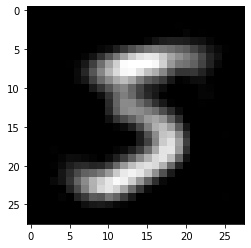

In [57]:
pyplot.imshow(model(xt_ds[0]).detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
yb.size()

In [60]:
print("Loss of the model:", loss_func(model(xb), yb))
print("Loss of Binear Interpolation:", loss_func(xt_us, x_train))



Loss of the model: tensor(0.0187, grad_fn=<MeanBackward0>)
Loss of Binear Interpolation: tensor(0.0108)


>Using torch.nn.functional
------------------------------

>We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible.

>The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes). As well as a wide range of loss and activation
functions, you'll also find here some convenient functions for creating neural
nets, such as pooling functions. (There are also functions for doing convolutions,
linear layers, etc, but as we'll see, these are usually better handled using
other parts of the library.)

>If you're using negative log likelihood loss and log softmax activation,
then Pytorch provides a single function ``F.cross_entropy`` that combines
the two. So we can even remove the activation function from our model.

We cannot use cross entropy
So we use relu and mse and we put the activation function back into the loss function


In [61]:
import torch.nn.functional as F

loss_func = F.mse_loss
activ_func = F.relu

def model(xb):
    return activ_func(xb @ weights + bias)

In [62]:
print(torch.min(model(xb)))

tensor(0., grad_fn=<MinBackward1>)


>Note that we no longer call ``log_softmax`` in the ``model`` function. Let's
confirm that our loss and accuracy are the same as before:

Ok that's fixed

In [63]:
loss_func(model(xb), yb)


tensor(0.0188, grad_fn=<MseLossBackward>)

Refactor using nn.Module
-----------------------------
Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.

<div class="alert alert-info"><h4>Note</h4><p>``nn.Module`` (uppercase M) is a PyTorch specific concept, and is a
   class we'll be using a lot. ``nn.Module`` is not to be confused with the Python
   concept of a (lowercase ``m``) `module <https://docs.python.org/3/tutorial/modules.html>`_,
   which is a file of Python code that can be imported.</p></div>



In [135]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 784) / 784)
        self.bias = nn.Parameter(torch.zeros(784))

    def forward(self, xb):
        return activ_func(xb @ self.weights + self.bias)

Since we're now using an object instead of just using a function, we
first have to instantiate our model:



In [139]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that
``nn.Module`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our ``forward``
method automatically.



In [140]:
print(loss_func(model(xb), yb))

tensor(0.1144, grad_fn=<MseLossBackward>)


Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:
::
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()


Now we can take advantage of model.parameters() and model.zero_grad() (which
are both defined by PyTorch for ``nn.Module``) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()


We'll wrap our little training loop in a ``fit`` function so we can run it
again later.



In [141]:
pred = model(xb)
xb.size()
bs
x_train.size()

torch.Size([50000, 784])

In [143]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = xt_us[start_i:end_i]
            yb = x_train[start_i:end_i]
            xb.size()
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let's double-check that our loss has gone down:



In [80]:
print(loss_func(model(xb), yb))

tensor(0.0082, grad_fn=<MseLossBackward>)


In [90]:
x_sample = model(xt_ds[0:100])
y_sample = x_train[0:100]



def testTensors(x, y):
    mse = []
    ssim = []
    x = x.detach().numpy()
    y = y.detach().numpy()
    for i in range(100):
        mse.append(np.average(np.square(y[i]-x[i])))
        ssim.append(compare_ssim(y[i],x[i]))
    return [np.mean(mse), np.mean(ssim)]

print(testTensors(x_sample, y_sample))
        
#     e5_mse =  
# from skimage.measure import compare_ssim as ssim
# print("The MSE of bicubic interpolation on this image is", e5_mse)
# e5_ssim = 
# print("The SSIM of bicubic interpolation on this image is", e5_ssim)
print(x_sample.shape)

print(np.mean(mse))
print(np.mean(ssim))

[0.0071407687, 0.9117204455330581]
torch.Size([100, 784])
nan
nan


/projects/qg35/jlgao2/venvs/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


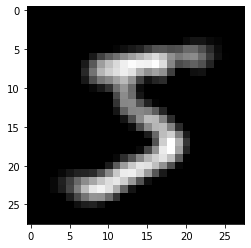

In [93]:
pyplot.imshow(x_sample[0].detach().numpy().reshape((28,28)), cmap='gray')

Refactor using nn.Linear
-------------------------

We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
`nn.Linear <https://pytorch.org/docs/stable/nn.html#linear-layers>`_ for a
linear layer, which does all that for us. Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.



In [122]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 784)

    def forward(self, xb):
        return activ_func(self.lin(xb))

We instantiate our model and calculate the loss in the same way as before:



In [123]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(0.1094, grad_fn=<MseLossBackward>)


We are still able to use our same ``fit`` method as before.



Refactor using optim
------------------------------

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

and instead use just:
::
  opt.step()
  opt.zero_grad()

(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)



In [100]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [144]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = xt_us[start_i:end_i]
        yb = x_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.1145, grad_fn=<MseLossBackward>)
tensor(0.0119, grad_fn=<MseLossBackward>)


In [134]:
xt_us.size()

torch.Size([50000, 784])

In [102]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [120]:
train_ds = TensorDataset(xt_us, x_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(xv_us, x_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



Create fit() and get_data()
----------------------------------

We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [112]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.



In [149]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` returns dataloaders for the training and validation sets.



In [185]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [186]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.043536354666948315
1 0.034637879544496535
2 0.02981453269124031
3 0.026702913030982017
4 0.024470594796538354
5 0.02276384028196335
6 0.02131422400176525
7 0.02016535888314247
8 0.01920258931517601
9 0.018377615958452224
10 0.017659854301810263
11 0.017027694776654244
12 0.016467397597432137
13 0.015964249891042708
14 0.015511864733695984
15 0.015098925122618675
16 0.014722148871421814
17 0.014376439225673675
18 0.014057751497626305
19 0.013763205996155738


You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN
-------------

We are now going to build our neural network with three convolutional layers.
Because none of the functions in the previous section assume anything about
the model form, we'll be able to use them to train a CNN without any modification.

We will use Pytorch's predefined
`Conv2d <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`_ class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



`Momentum <https://cs231n.github.io/neural-networks-3/#sgd>`_ is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [ ]:
model(xb).size()

In [180]:
yb.size()

torch.Size([16, 784])

nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simply our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [200]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

The model created with ``Sequential`` is simply:



Wrapping DataLoader
-----------------------------

Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer but
moving the data preprocessing into a generator:



In [201]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [183]:
model = nn.Sequential(
            #28*28*1
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #14*14*16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #14*14*32
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #28x28x16
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=1, padding=1, bias=False)
            #28x28x1   
        )

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [187]:
print(torch.cuda.is_available())

True


And then create a device object for it:



In [188]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [206]:
def preprocess(x, y):
    return x.to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



In [204]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

You should find it runs faster now:



In [215]:
fit(30, model, loss_func, opt, train_dl, valid_dl)

0 0.006070752645283938
1 0.006013445632904768
2 0.005957098051160574
3 0.005905575553327799
4 0.005858712063729763
5 0.005814067430049181
6 0.005769696255773306
7 0.0057284526631236074
8 0.005689675119519234
9 0.0056561275467276574
10 0.00561918348968029
11 0.00558917403370142
12 0.005557484621554613
13 0.005526570887118578
14 0.005500036523491144
15 0.0054724472790956494
16 0.005446424344927072
17 0.005421431645005941
18 0.005398137820512057
19 0.00537549922093749
20 0.0053534118108451365
21 0.0053330804571509365
22 0.005311884227395058
23 0.00529219608977437
24 0.0052737728275358674
25 0.005255887055397034
26 0.005237679877877236
27 0.0052215172566473485
28 0.005204095690697431
29 0.0051886571899056435


In [216]:
x_sample = model(xt_us[0:100].to(dev)).to('cpu')
y_sample = x_train[0:100]

def testTensors(x, y):
    mse = []
    ssim = []
    x = x.detach().numpy()
    y = y.detach().numpy()
    for i in range(100):
        mse.append(np.average(np.square(y[i]-x[i])))
        ssim.append(compare_ssim(y[i],x[i]))
    return [np.mean(mse), np.mean(ssim)]

print(testTensors(x_sample, y_sample))
        
#     e5_mse =  
# from skimage.measure import compare_ssim as ssim
# print("The MSE of bicubic interpolation on this image is", e5_mse)
# e5_ssim = 
# print("The SSIM of bicubic interpolation on this image is", e5_ssim)
print(x_sample.shape)

print(np.mean(mse))
print(np.mean(ssim))


[0.0051259575, 0.9390531106113823]
torch.Size([100, 784])
nan
nan


/projects/qg35/jlgao2/venvs/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()


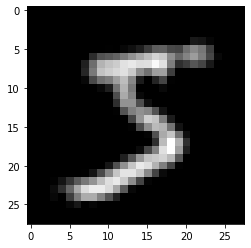

In [217]:
img_cnn = pyplot.imshow(x_sample[0].detach().numpy().reshape((28,28)), cmap='gray')

Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. To see how simple training a model
can now be, take a look at the `mnist_sample` sample notebook.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

